# Depth-to-normal

Convert depth maps into surface normal maps

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import sys
sys.path.append('../')

from cross import d2n_tblr
from plane_svd import Depth2normal as d2n_svd

Here we have an image (`lab_01.png` from the [iBims-1](https://paperswithcode.com/dataset/ibims-1) dataset)

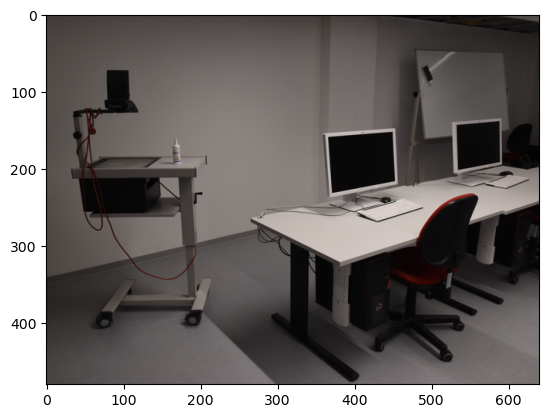

In [3]:
img = Image.open('./img.png')
plt.imshow(img)

The corresponding depth map is in `dtype=uint16` and should be divided by `1000.0` in order to get the metric depth. (NOTE: the format of depth map is different in different datasets.)

In [4]:
# depth should be a torch tensor of shape (1, 1, H, W)
depth = np.array(Image.open('./depth.png'))[:, :, np.newaxis].astype(np.float32) / 1000.0
depth = torch.from_numpy(depth).permute(2, 0, 1).unsqueeze(0)    # (1, 1, H, W)
depth = depth.to(0)

We now need the camera intrinsics.

In [5]:
def get_intrins(intrins_path):
    with open(intrins_path, 'r') as f:
        intrins_ = f.readlines()[0].split()[0].split(',')
        intrins_ = [float(i) for i in intrins_]
        fx, fy, cx, cy = intrins_

    intrins = torch.tensor([[fx, 0.0, cx],
                        [0.0, fy, cy],
                        [0.0, 0.0, 1.0]], dtype=torch.float, device=0)
    
    intrins_inv = torch.tensor([[1/fx, 0.0, -cx/fx],
                        [0.0, 1/fy, -cy/fx],
                        [0.0, 0.0, 1.0]], dtype=torch.float, device=0)

    return intrins, intrins_inv

In [6]:
_, intrins_inv = get_intrins('./camera.txt')

The following gives you a tensor `pixel_coords` of shape (1, 3, H, W). 

`pixel_coords[0,0,H,W]` and `pixel_coords[0,1,H,W]` are the `u` and `v` coordinates.

In [7]:
def get_pixel_coords(depth):
    _, _, h, w = depth.size()
    u_range = torch.arange(0, w).view(1, w).expand(h, w).type_as(depth) # (H, W)
    v_range = torch.arange(0, h).view(h, 1).expand(h, w).type_as(depth) # (H, W)
    ones = torch.ones(h, w).type_as(depth)
    pixel_coords = torch.stack((u_range, v_range, ones), dim=0).unsqueeze(0)      # (1, 3, H, W)
    return pixel_coords

We can now compute the camera coordinates.

In [8]:
b, _, h, w = depth.size()
pixel_coords = get_pixel_coords(depth)
current_pixel_coords = pixel_coords.view(b, 3, -1)
intrins_inv = intrins_inv.unsqueeze(0)
cam_coords = intrins_inv.bmm(current_pixel_coords).view(b, 3, h, w)     # ray of unit depth
points = cam_coords * depth                                             # multiply by depth

### Option 1. Do a cross-product

The easiest way to compute the normal vectors would be to do a cross product between two tangential vectors.

In [9]:
normal, valid_mask = d2n_tblr(points, k=7, d_min=1e-3, d_max=10.0)

* `normal`: tensor of surface normal vectors, shape: (B, 3, H, W)
* `valid_mask`: boolean tensor of shape (B, 1, H, W), True for pixels with valid surface normal

We can now visualize the surface normals in RGB

In [10]:
def normal_to_rgb(norm, valid_mask):
    norm_uint8 = ((norm + 1) * 0.5) * 255
    norm_uint8 = np.clip(norm_uint8, 0, 255)
    norm_uint8 = norm_uint8.astype(np.uint8)
    norm_uint8 = norm_uint8 * valid_mask.astype(np.uint8)
    return norm_uint8

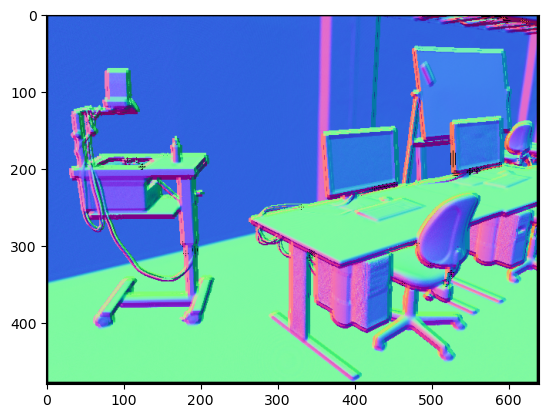

In [11]:
normal = normal.detach().cpu().permute(0, 2, 3, 1).numpy()
valid_mask = valid_mask.detach().cpu().permute(0, 2, 3, 1).numpy()
normal_rgb = normal_to_rgb(normal, valid_mask)[0, ...]

plt.imshow(normal_rgb)

### Option 2. Do PlaneSVD

Or we can do PlaneSVD. 

We can filter out nghbr pixels if their depth is largely different from the center pixel. This can improve the quality of the computed normals near depth discontinuities.

In [12]:
with torch.no_grad():
    D2N = d2n_svd(d_min=1e-3, d_max=10.0, k=7, d=1, gamma=0.05, min_nghbr=4)
    normal, valid_mask = D2N(points)

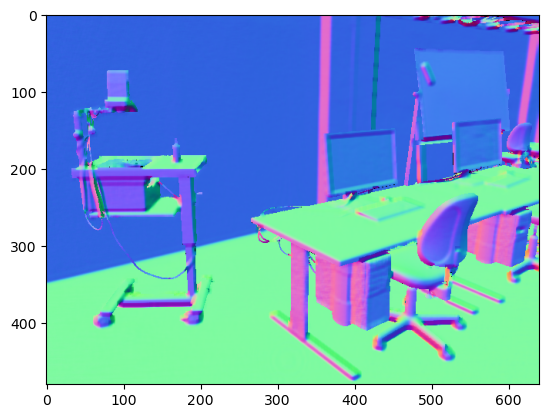

In [13]:
normal = normal.detach().cpu().permute(0, 2, 3, 1).numpy()
valid_mask = valid_mask.detach().cpu().permute(0, 2, 3, 1).numpy()
normal_rgb = normal_to_rgb(normal, valid_mask)[0, :, ...]

plt.imshow(normal_rgb)